# 1. IMPORT

In [1]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from pytorchtools import EarlyStopping

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# 하이퍼파라미터 설정

In [7]:
import os
os.getcwd()

'/home/work/CL/largecode2modify'

In [8]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.000005
        self.batch_size=16
        self.shuffle = True
        self.seed=500
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/healthcare/healthcare5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [10]:
# trainset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
# testset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
# valset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

trainset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

In [11]:
trainset['수도라벨'].value_counts()

8    618
7    609
9    583
6    579
5    561
Name: 수도라벨, dtype: int64

In [12]:
for i in range(20):
    
    save_path = f"/home/work/CL/dataset/healthcare/16_desc{i+1}_combined.csv"
    globals()['trainset{}'.format(i+1)]= pd.read_csv(save_path)

# 토크나이저와 모델 정의

In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)
# model = torch.nn.DataParallel(model)
# model = get_peft_model(model, peft_config).to(device)

# model.print_trainable_parameters()
# model


<All keys matched successfully>

# 커스텀 데이터셋

In [14]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [15]:
import pandas as pd

dataframes = []  # 데이터프레임 리스트 초기화

for i in range(1, 21):
    trainset = globals()[f"trainset{i}"]  # 동적으로 변수명을 활용하여 데이터프레임 가져오기
    dataframes.append(trainset)  # 데이터프레임 리스트에 추가

In [16]:
# 데이터프레임을 데이터셋으로 변환
datasets = []
for trainset in dataframes:
    dataset = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                            labels=list(trainset['수도라벨'].copy()),
                            tokenizer=tokenizer,
                            source_len=cfg.source_len)
    datasets.append(dataset)

# 데이터로더 생성
batch_size = 16
data_loaders = []
for dataset in datasets:
    data_loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
    data_loaders.append(data_loader)
len(data_loaders)
# # 데이터로더 사용 예시
# for data_loader in data_loaders:
#     for batch in data_loader:
#         inputs_dict, label = batch
#         print(inputs_dict)
#         print(label)

20

In [17]:
# train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
#                            labels= list(trainset['수도라벨'].copy()),
#                            tokenizer= tokenizer,
#                            source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

# train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [18]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [19]:
def validate(epoch, model, loader):
   
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [20]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return t_avg_loss, t_avg_acc
    
        

# RUN

In [21]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.000005)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.* (len(data_loader) * cfg.epochs),
    num_training_steps=(len(data_loader) * cfg.epochs),
)

In [22]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)


for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, data_loaders[epoch])
    lr_scheduler.step()

    validate(epoch, model, val_loader)
    
    # if early_stopping.early_stop:
    #     break
    torch.save(model, f'/home/work/CL/final_healthmodel/desc_{epoch+1}epoch.pt')

    
    

df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_healthmodel/desc.xlsx', index=False)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 6.113699913024902
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 1.539410948753357
1_32_step_정확도 :0.3125
Epoch : 1, train_64_step_loss : 1.50761079788208
1_64_step_정확도 :0.1875
Epoch : 1, train_96_step_loss : 0.9237905740737915
1_96_step_정확도 :0.625
Epoch : 1, train_128_step_loss : 0.7455617785453796
1_128_step_정확도 :0.875
Epoch : 1, train_160_step_loss : 1.080909013748169
1_160_step_정확도 :0.6875
Epoch:1, train_183_stepLoss:1.4181596296636954
Epoch:1, train_183_stepacc:0.492866847826087
Epoch:1, train_183_stepacc:0.492866847826087
Epoch : 1, val_0_step_loss : 0.5893287062644958
1_0_step_정확도 :0.8125
Epoch : 1, val_32_step_loss : 1.5356837511062622
1_32_step_정확도 :0.5
Epoch:1, val_61_stepLoss:0.9504704254288827
Epoch:1, val_61_stepacc:0.631192396313364
Epoch:1, val_61_stepacc:0.631192396313364
Validation loss decreased (inf --> 0.950470).  Saving model ...


 10%|█         | 1/10 [01:30<13:34, 90.55s/it]

Epoch : 2, train_0_step_loss : 0.9198676347732544
2_0_step_정확도 :0.75
Epoch : 2, train_32_step_loss : 1.0530788898468018
2_32_step_정확도 :0.5625
Epoch : 2, train_64_step_loss : 0.9241870045661926
2_64_step_정확도 :0.5625
Epoch : 2, train_96_step_loss : 0.5094843506813049
2_96_step_정확도 :0.8125
Epoch : 2, train_128_step_loss : 0.5838605761528015
2_128_step_정확도 :0.8125
Epoch : 2, train_160_step_loss : 0.8424304723739624
2_160_step_정확도 :0.75
Epoch:2, train_183_stepLoss:0.809132809062367
Epoch:2, train_183_stepacc:0.7010869565217391
Epoch:2, train_183_stepacc:0.7010869565217391
Epoch : 2, val_0_step_loss : 0.5384502410888672
2_0_step_정확도 :0.8125
Epoch : 2, val_32_step_loss : 1.4714553356170654
2_32_step_정확도 :0.5
Epoch:2, val_61_stepLoss:0.9052565203559014
Epoch:2, val_61_stepacc:0.6826036866359446
Epoch:2, val_61_stepacc:0.6826036866359446
Validation loss decreased (0.950470 --> 0.905257).  Saving model ...


 20%|██        | 2/10 [03:00<11:59, 89.99s/it]

Epoch : 3, train_0_step_loss : 0.5867863297462463
3_0_step_정확도 :0.75
Epoch : 3, train_32_step_loss : 0.8246089816093445
3_32_step_정확도 :0.75
Epoch : 3, train_64_step_loss : 0.7880029678344727
3_64_step_정확도 :0.5625
Epoch : 3, train_96_step_loss : 0.3294336795806885
3_96_step_정확도 :0.875
Epoch : 3, train_128_step_loss : 0.4979349970817566
3_128_step_정확도 :0.8125
Epoch : 3, train_160_step_loss : 0.6677520871162415
3_160_step_정확도 :0.8125
Epoch:3, train_183_stepLoss:0.6120776402885499
Epoch:3, train_183_stepacc:0.7815896739130435
Epoch:3, train_183_stepacc:0.7815896739130435
Epoch : 3, val_0_step_loss : 0.5837879776954651
3_0_step_정확도 :0.875
Epoch : 3, val_32_step_loss : 1.157016396522522
3_32_step_정확도 :0.6875
Epoch:3, val_61_stepLoss:0.9712969362735748
Epoch:3, val_61_stepacc:0.690668202764977
Epoch:3, val_61_stepacc:0.690668202764977
EarlyStopping counter: 1 out of 3


 30%|███       | 3/10 [04:27<10:20, 88.69s/it]

Epoch : 4, train_0_step_loss : 0.3788653612136841
4_0_step_정확도 :0.875
Epoch : 4, train_32_step_loss : 0.7339625954627991
4_32_step_정확도 :0.75
Epoch : 4, train_64_step_loss : 0.48915761709213257
4_64_step_정확도 :0.875
Epoch : 4, train_96_step_loss : 0.20681683719158173
4_96_step_정확도 :0.9375
Epoch : 4, train_128_step_loss : 0.34804677963256836
4_128_step_정확도 :0.875
Epoch : 4, train_160_step_loss : 0.47172781825065613
4_160_step_정확도 :0.9375
Epoch:4, train_183_stepLoss:0.4559054833472423
Epoch:4, train_183_stepacc:0.8539402173913043
Epoch:4, train_183_stepacc:0.8539402173913043
Epoch : 4, val_0_step_loss : 0.615261435508728
4_0_step_정확도 :0.875
Epoch : 4, val_32_step_loss : 1.5359100103378296
4_32_step_정확도 :0.625
Epoch:4, val_61_stepLoss:1.0536533041346459
Epoch:4, val_61_stepacc:0.6893721198156683
Epoch:4, val_61_stepacc:0.6893721198156683
EarlyStopping counter: 2 out of 3


 40%|████      | 4/10 [05:54<08:48, 88.07s/it]

Epoch : 5, train_0_step_loss : 0.39311614632606506
5_0_step_정확도 :0.875
Epoch : 5, train_32_step_loss : 0.5170649886131287
5_32_step_정확도 :0.875
Epoch : 5, train_64_step_loss : 0.20967264473438263
5_64_step_정확도 :0.875
Epoch : 5, train_96_step_loss : 0.17489667236804962
5_96_step_정확도 :0.9375
Epoch : 5, train_128_step_loss : 0.09584343433380127
5_128_step_정확도 :1.0
Epoch : 5, train_160_step_loss : 0.4327316880226135
5_160_step_정확도 :0.9375
Epoch:5, train_183_stepLoss:0.3361862087217362
Epoch:5, train_183_stepacc:0.8947010869565217
Epoch:5, train_183_stepacc:0.8947010869565217
Epoch : 5, val_0_step_loss : 0.819786012172699
5_0_step_정확도 :0.8125
Epoch : 5, val_32_step_loss : 1.0623105764389038
5_32_step_정확도 :0.6875
Epoch:5, val_61_stepLoss:1.136742095793447
Epoch:5, val_61_stepacc:0.6957085253456221
Epoch:5, val_61_stepacc:0.6957085253456221
EarlyStopping counter: 3 out of 3


 50%|█████     | 5/10 [07:21<07:17, 87.60s/it]

Epoch : 6, train_0_step_loss : 0.17708757519721985
6_0_step_정확도 :0.9375
Epoch : 6, train_32_step_loss : 0.42452389001846313
6_32_step_정확도 :0.9375
Epoch : 6, train_64_step_loss : 0.13857907056808472
6_64_step_정확도 :1.0
Epoch : 6, train_96_step_loss : 0.0808487981557846
6_96_step_정확도 :1.0
Epoch : 6, train_128_step_loss : 0.12437096238136292
6_128_step_정확도 :0.9375
Epoch : 6, train_160_step_loss : 0.4816315472126007
6_160_step_정확도 :0.875
Epoch:6, train_183_stepLoss:0.2772317765604543
Epoch:6, train_183_stepacc:0.9177989130434783
Epoch:6, train_183_stepacc:0.9177989130434783
Epoch : 6, val_0_step_loss : 0.7507309913635254
6_0_step_정확도 :0.875
Epoch : 6, val_32_step_loss : 1.665299654006958
6_32_step_정확도 :0.5
Epoch:6, val_61_stepLoss:1.261811589041064
Epoch:6, val_61_stepacc:0.6883640552995393
Epoch:6, val_61_stepacc:0.6883640552995393
EarlyStopping counter: 4 out of 3


 60%|██████    | 6/10 [08:47<05:49, 87.32s/it]

Epoch : 7, train_0_step_loss : 0.05591421574354172
7_0_step_정확도 :1.0
Epoch : 7, train_32_step_loss : 0.35110628604888916
7_32_step_정확도 :0.9375
Epoch : 7, train_64_step_loss : 0.09238007664680481
7_64_step_정확도 :1.0
Epoch : 7, train_96_step_loss : 0.04985097423195839
7_96_step_정확도 :1.0
Epoch : 7, train_128_step_loss : 0.0468236468732357
7_128_step_정확도 :1.0
Epoch : 7, train_160_step_loss : 0.6342398524284363
7_160_step_정확도 :0.8125
Epoch:7, train_183_stepLoss:0.19652456506762817
Epoch:7, train_183_stepacc:0.9415760869565217
Epoch:7, train_183_stepacc:0.9415760869565217
Epoch : 7, val_0_step_loss : 0.7396401166915894
7_0_step_정확도 :0.875
Epoch : 7, val_32_step_loss : 1.5612092018127441
7_32_step_정확도 :0.625
Epoch:7, val_61_stepLoss:1.150224360967836
Epoch:7, val_61_stepacc:0.7236463133640554
Epoch:7, val_61_stepacc:0.7236463133640554
EarlyStopping counter: 5 out of 3


 70%|███████   | 7/10 [10:14<04:21, 87.19s/it]

Epoch : 8, train_0_step_loss : 0.08971171081066132
8_0_step_정확도 :1.0
Epoch : 8, train_32_step_loss : 0.3803366422653198
8_32_step_정확도 :0.9375
Epoch : 8, train_64_step_loss : 0.11310108751058578
8_64_step_정확도 :0.9375
Epoch : 8, train_96_step_loss : 0.07257141917943954
8_96_step_정확도 :1.0
Epoch : 8, train_128_step_loss : 0.31051892042160034
8_128_step_정확도 :0.8125
Epoch : 8, train_160_step_loss : 0.38789379596710205
8_160_step_정확도 :0.8125
Epoch:8, train_183_stepLoss:0.15956371304903016
Epoch:8, train_183_stepacc:0.9500679347826086
Epoch:8, train_183_stepacc:0.9500679347826086
Epoch : 8, val_0_step_loss : 0.9921579360961914
8_0_step_정확도 :0.75
Epoch : 8, val_32_step_loss : 1.5350751876831055
8_32_step_정확도 :0.625
Epoch:8, val_61_stepLoss:1.2485344957920812
Epoch:8, val_61_stepacc:0.7004608294930876
Epoch:8, val_61_stepacc:0.7004608294930876
EarlyStopping counter: 6 out of 3


 80%|████████  | 8/10 [11:41<02:54, 87.09s/it]

Epoch : 9, train_0_step_loss : 0.04097506031394005
9_0_step_정확도 :1.0
Epoch : 9, train_32_step_loss : 0.3437402844429016
9_32_step_정확도 :0.9375
Epoch : 9, train_64_step_loss : 0.10988974571228027
9_64_step_정확도 :0.9375
Epoch : 9, train_96_step_loss : 0.12079201638698578
9_96_step_정확도 :0.9375
Epoch : 9, train_128_step_loss : 0.07516217976808548
9_128_step_정확도 :1.0
Epoch : 9, train_160_step_loss : 0.3127824366092682
9_160_step_정확도 :0.9375
Epoch:9, train_183_stepLoss:0.11433210802446726
Epoch:9, train_183_stepacc:0.9670516304347826
Epoch:9, train_183_stepacc:0.9670516304347826
Epoch : 9, val_0_step_loss : 0.7454526424407959
9_0_step_정확도 :0.875
Epoch : 9, val_32_step_loss : 1.2910270690917969
9_32_step_정확도 :0.625
Epoch:9, val_61_stepLoss:1.2495884179107604
Epoch:9, val_61_stepacc:0.7246543778801844
Epoch:9, val_61_stepacc:0.7246543778801844
EarlyStopping counter: 7 out of 3


 90%|█████████ | 9/10 [13:09<01:27, 87.27s/it]

Epoch : 10, train_0_step_loss : 0.01897609978914261
10_0_step_정확도 :1.0
Epoch : 10, train_32_step_loss : 0.4390561282634735
10_32_step_정확도 :0.875
Epoch : 10, train_64_step_loss : 0.01882864162325859
10_64_step_정확도 :1.0
Epoch : 10, train_96_step_loss : 0.07353178411722183
10_96_step_정확도 :0.9375
Epoch : 10, train_128_step_loss : 0.01936088502407074
10_128_step_정확도 :1.0
Epoch : 10, train_160_step_loss : 0.19147951900959015
10_160_step_정확도 :0.9375
Epoch:10, train_183_stepLoss:0.09095382530991312
Epoch:10, train_183_stepacc:0.9714673913043478
Epoch:10, train_183_stepacc:0.9714673913043478
Epoch : 10, val_0_step_loss : 0.949192225933075
10_0_step_정확도 :0.75
Epoch : 10, val_32_step_loss : 1.6316978931427002
10_32_step_정확도 :0.5625
Epoch:10, val_61_stepLoss:1.3410656012354358
Epoch:10, val_61_stepacc:0.7165898617511521
Epoch:10, val_61_stepacc:0.7165898617511521
EarlyStopping counter: 8 out of 3


100%|██████████| 10/10 [14:36<00:00, 87.63s/it]


In [23]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,1.418160,0.950470,0.492867,0.631192
1,2,0.809133,0.905257,0.701087,0.682604
2,3,0.612078,0.971297,0.781590,0.690668
3,4,0.455905,1.053653,0.853940,0.689372
4,5,0.336186,1.136742,0.894701,0.695709
5,6,0.277232,1.261812,0.917799,0.688364
6,7,0.196525,1.150224,0.941576,0.723646
7,8,0.159564,1.248534,0.950068,0.700461
8,9,0.114332,1.249588,0.967052,0.724654
9,10,0.090954,1.341066,0.971467,0.716590


In [24]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

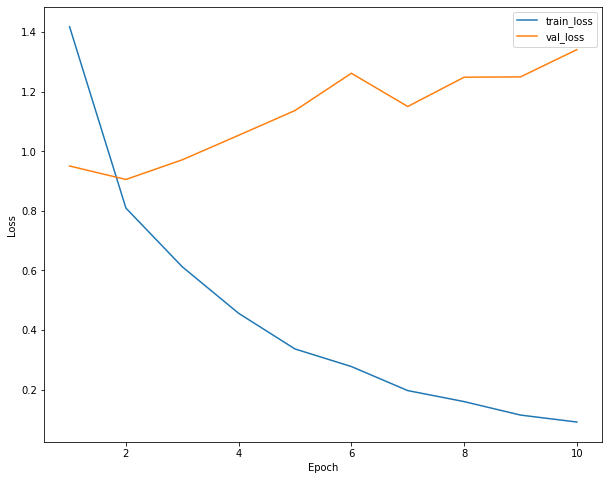

In [25]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_dic['epoch'],loss_dic['train_loss'],label='train_loss')
plt.plot(loss_dic['epoch'],loss_dic['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

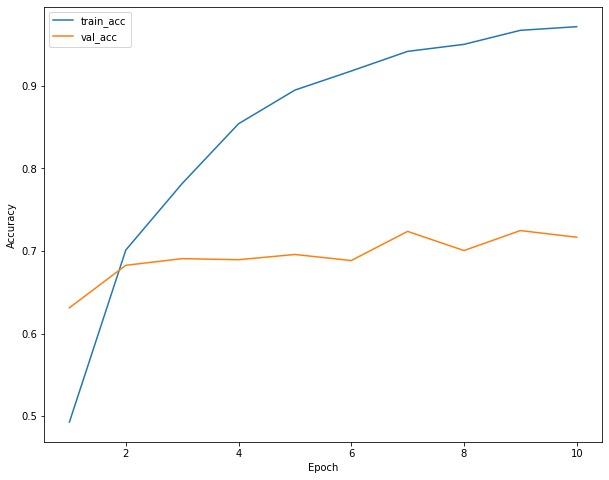

In [26]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(loss_dic['epoch'],loss_dic['train_acc'],label='train_acc')
plt.plot(loss_dic['epoch'],loss_dic['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

## 2번 도메인까지 학습한뒤 평가(정렬된거기준)

### 1에폭 모델

In [27]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

for i in range(20) :
    save_path = f"/home/work/CL/final_healthmodel/desc_{i+1}epoch.pt"
    model = torch.load(save_path)

    print(i+1,infer(model=model,loader=test_loader))



62it [00:07,  7.81it/s]


test_61_stepLoss:0.9119860784661385
test_61_stepacc:0.6451612903225806
1 (0.9119860784661385, 0.6451612903225806)


62it [00:07,  7.85it/s]


test_61_stepLoss:0.8405860477397519
test_61_stepacc:0.6834677419354839
2 (0.8405860477397519, 0.6834677419354839)


62it [00:07,  7.80it/s]


test_61_stepLoss:0.8969389034375068
test_61_stepacc:0.6985887096774194
3 (0.8969389034375068, 0.6985887096774194)


62it [00:07,  7.85it/s]


test_61_stepLoss:1.0194476496788762
test_61_stepacc:0.6844758064516129
4 (1.0194476496788762, 0.6844758064516129)


62it [00:07,  7.85it/s]


test_61_stepLoss:1.1152666778333726
test_61_stepacc:0.6814516129032258
5 (1.1152666778333726, 0.6814516129032258)


62it [00:07,  7.78it/s]


test_61_stepLoss:1.231787346303463
test_61_stepacc:0.6834677419354839
6 (1.231787346303463, 0.6834677419354839)


62it [00:08,  7.71it/s]


test_61_stepLoss:1.1250882124708546
test_61_stepacc:0.7106854838709677
7 (1.1250882124708546, 0.7106854838709677)


62it [00:07,  7.85it/s]


test_61_stepLoss:1.3259658529873817
test_61_stepacc:0.6834677419354839
8 (1.3259658529873817, 0.6834677419354839)


62it [00:07,  7.83it/s]


test_61_stepLoss:1.311343540587733
test_61_stepacc:0.7006048387096774
9 (1.311343540587733, 0.7006048387096774)


62it [00:07,  7.82it/s]


test_61_stepLoss:1.318890865772001
test_61_stepacc:0.7227822580645161
10 (1.318890865772001, 0.7227822580645161)


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/CL/final_healthmodel/desc_11epoch.pt'